In [1]:
%matplotlib inline

In [2]:
# import all necessary libraries
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import math

from dv import AedatFile
import cv2
from time import sleep

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

In [3]:
with AedatFile("./data/constant_652.4-2022_03_23_16_03_05.aedat4") as f:
    # list all the names of streams in the file
    print(f.names)

    # Access dimensions of the event stream
    height, width = f['events'].size

    # # loop through the "events" stream
    # for e in f['events']:
    #     print(e.timestamp)

    # loop through the "frames" stream
    # for frame in f['frames']:
    #     #print(frame.timestamp)
    #     plt.imshow(frame.image)
    #     sleep(0.05)

['events', 'frames', 'imu', 'triggers']


### Import as numpy file

In [3]:
with AedatFile("./data/constant_652.4-2022_03_23_16_03_05.aedat4") as f:
    # events will be a named numpy array
    events = np.hstack([packet for packet in f['events'].numpy()])

    # Access information of all events by type
    # t, x, y, p = events['timestamp'], events['x'], events['y'], events['polarity']
    
    # Access individual events information
    event_123_x = events[123]['x']


    # Get first 1000 events
    sliced_events = events[100000:200000]
    t, x, y, p = sliced_events['timestamp'], sliced_events['x'], sliced_events['y'], sliced_events['polarity']

### Import simulation file

In [26]:
# from numpy import genfromtxt 

# x, y = genfromtxt('./data/sim/x.csv', delimiter=','), genfromtxt('./data/sim/y.csv', delimiter=',')
# t, p = genfromtxt('./data/sim/t.csv', delimiter=','), genfromtxt('./data/sim/p.csv', delimiter=',')

# # Combine into tuple 
# event_tuple = list(zip(x,y,t,p))

# events = np.array(event_tuple,dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

In [4]:
events['x'], events['y'], events['polarity'], events['timestamp'] # time in microseconds..

(array([132,  62,  15, ..., 284, 284, 218], dtype=int16),
 array([230, 125, 177, ..., 148, 255, 190], dtype=int16),
 array([1, 1, 1, ..., 0, 0, 0], dtype=int8),
 array([1648065785453482, 1648065785453483, 1648065785453485, ...,
        1648065797133457, 1648065797133461, 1648065797133470], dtype=int64))

In [5]:
print(np.max(events['polarity']), np.min(events['polarity']))

1 0


### plot 3d (turn into function)

<ipython-input-6-3b4ac20dac12>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


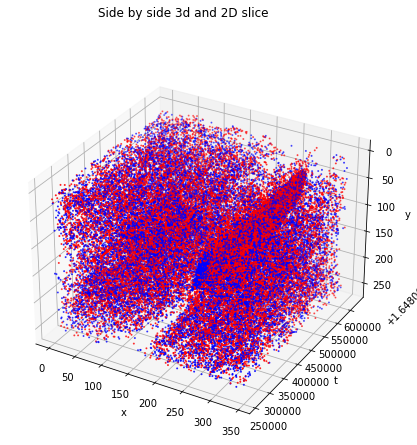

In [6]:
fig = plt.figure(figsize=(14,7))
fig.suptitle('Side by side 3d and 2D slice ')
ax = fig.add_subplot(111, projection='3d') 

# Data for three-dimensional scattered points
zdata = y
xdata = x
ydata = t
polarity = p
ax.scatter3D(xdata, ydata, zdata, c=polarity, cmap= 'bwr', s=1)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.invert_zaxis()

#2d time surface slice 
#ax = fig.add_subplot(212)
fig.show()

### Convert to structured array

In [7]:
import tonic.transforms as transforms
import tonic

# convert to tonic recognized format
structured_array  = tonic.io.make_structured_array(x,y,t,p)

sampling_period = 500 # in microseconds

frame_transform = transforms.ToFrame(sensor_size=(int(sliced_events["x"].max() + 1),int(sliced_events["y"].max() + 1),2), time_window=sampling_period)
frames = frame_transform(structured_array) # numpy array with dimensions (TxPxHxW)
print("Data dimensions: ", np.shape(frames))
print(np.shape(frames[0]))

Data dimensions:  (733, 2, 260, 346)
(2, 260, 346)


In [8]:
structured_array # this is arranged with increasing timestamp...

array([( 35,  63, 1648065786258113, False),
       (185, 147, 1648065786258128,  True),
       (268,  48, 1648065786258130,  True), ...,
       ( 26,  19, 1648065786624689,  True),
       (262,  71, 1648065786624693, False),
       (258,  93, 1648065786624705, False)],
      dtype=[('x', '<i2'), ('y', '<i2'), ('t', '<i8'), ('p', '?')])

### Apply Gabor pixelwise according to eqn 9 in algorithm 1 (not implemented fully)

In [12]:
from skimage.filters import gabor

def normalize(data): 
    image = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8') # First normalize to 0-255
    return image

### Apply gabor filter to each NxN (10x10) region 

# Loop through all the events and convert to time surface!
N = 10 # neigbourhood size
s_hat = np.ones((N, N))
delta_t = 200  # check units later...
start_i = 0

frame_transform = transforms.ToFrame(sensor_size=(int(sliced_events["x"].max() + 1), # Transform to accumulate events delta_t units ago
                        int(sliced_events["y"].max() + 1),2), time_window=delta_t) 

Output_phase = ... #????? Define this somehow...

# First, find index after time delta_t has passed (start_i)
for i in range(len(structured_array)): 
    if(structured_array[i][2] >= (structured_array[0][2] + delta_t)): 
        start_i = i 
        break 

# Note: Calculate s_hat one by one, and assign time stamp according to time t... (eqn 8)
for i in range(start_i, len(structured_array)): 

    # For each event, create a temporary NxN array around the event! 
    s_hat = np.ones((N, N))
    x_hat,y_hat,t_hat,p_hat = [], [], [], [] # note p_hat always 1 (ignore polarity)
    
    # Spatial neighbourhood limits
    x_hat_max, x_hat_min = structured_array[i][0] + N/2, structured_array[i][0] - N/2
    y_hat_max, y_hat_min = structured_array[i][1] + N/2, structured_array[i][1] - N/2 

    t = structured_array[i][2] # timestamp 

    for j in range(i, len(structured_array)): # find events that are within spatial neighbourhood      
        
        # if more than delta_t (eqn 8), break from j loop
        if(structured_array[j][2] > (structured_array[i][2] + delta_t)):
            break

        # get all spatial neighbourhood variables
        if(structured_array[j][0] < x_hat_max and (structured_array[j][0] > x_hat_min) 
            and structured_array[i][1] < y_hat_max and (structured_array[j][1] > y_hat_min )):

            x_hat.append(structured_array[j][0])
            y_hat.append(structured_array[j][1])
            t_hat.append(structured_array[j][2])
            p_hat.append(1) # Any event will be assumed as 1.

    # Create s_hat from spatial neighbourhood events 
    neighbourhood = tonic.io.make_structured_array(x_hat,y_hat,t_hat,p_hat) 
    S = frame_transform(neighbourhood) # numpy array with dimensions (TxPxHxW)
    assert np.shape(S)[0] == 1 # Sanity check, only one frame: eqn 8 evaluated at NxN neighbourhood and at time t of event. 
    
    # Only get NxN centered at event! ie, crop S to s_hat...
    s_hat = S[x_hat_min:x_hat_max, y_hat_min:y_hat_max]

    # Then Apply gabor filter to s_hat
    re, im = gabor(normalize(s_hat), frequency = 0.9, sigma_x= 4, sigma_y=2, offset= 1) 
    phase = np.angle(re + 1j*im)
    print("Data dimensions: ", np.shape(phase))
    print(np.shape(phase))

    # Apply smoothing filter (later)

    # record time stamps for each event! 


    # Align phase matrix with response, and assign time stamps for all surrounding pixels


    # Return local phase signals for each pixel
     


# Interpolate timestamps linearly 

AssertionError: 

### Test

Apply Gabor frame by frame 

In [9]:
from skimage.filters import gabor
from skimage import data, io
from matplotlib import pyplot as plt
import math

### Apply Gabor filter frame by frame
gabor_filtered = []

def normalize(data): 
    image = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8') # First normalize to 0-255
    return image

for i in range(len(frames)):    
    # we only consider one polarity frames[i][0], should we consider the other one?
    re, im = gabor(normalize(frames[i][0]), frequency= 0.94 , sigma_x = 10.0 , 
    sigma_y = 10.0 , n_stds= 3 , theta= -0.0326990816 , offset= 1.0)  
    phase = np.imag(re + 1j*im)
    gabor_filtered.append(phase)

print("before", np.shape(gabor_filtered))
np.stack(gabor_filtered)
np.shape(gabor_filtered)

gabor_filtered = np.asarray(gabor_filtered)
print("After", np.shape(gabor_filtered)) # Takes about ~ 14 mins

<ipython-input-9-443def133ac9>:10: RuntimeWarning: divide by zero encountered in long_scalars
  image = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8') # First normalize to 0-255
<ipython-input-9-443def133ac9>:10: RuntimeWarning: invalid value encountered in multiply
  image = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8') # First normalize to 0-255


before (733, 260, 346)
After (733, 260, 346)


In [26]:
import scipy.io
scipy.io.savemat('lala.mat',dict(x=gabor_filtered))

### Visualize one gabor filter

In [31]:
%matplotlib qt 

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from IPython.display import display, clear_output
import time

# dashboard settings
fig, (ax, ax_2) = plt.subplots(1, 2, figsize=(10,10))
plt.subplots_adjust(left=0.25, bottom=0.45)

# create slider spaces
axcolor = 'lightgoldenrodyellow'
ax_sliders = [plt.axes([0.25, 0.1 + 0.05 * i, 0.65, 0.03], facecolor=axcolor) for i in range(7)]

# define parameter sliders
frequency = Slider(ax_sliders[0], 'frequency', 0.0, 2, valinit=0.9, valstep=0.01)
sigma_x = Slider(ax_sliders[1], 'sigma_x', 0.1, 20.0, valinit=10, valstep=0.1)
sigma_y = Slider(ax_sliders[2], 'sigma_y', 0.1, 20.0, valinit=10, valstep=0.1)
n_stds = Slider(ax_sliders[3], 'n_stds', 0.1, 20.0, valinit=3, valstep=0.1)
theta = Slider(ax_sliders[4], 'theta', -np.pi/8, np.pi/8, valinit=-0.033, valstep=0.01)
offset = Slider(ax_sliders[5], 'offset', -5, 5, valinit=1, valstep=0.1)
i = Slider(ax_sliders[6], 'i', 0, 600, valinit=150, valstep=1)

sliders = [frequency, sigma_x, sigma_y, n_stds, theta, offset,i]

def update(val):
    # on slider update recalculate gabor kernel
    re, im = gabor(normalize(frames[i.val][0]), frequency = frequency.val, theta = theta.val, sigma_x= sigma_x.val,
                sigma_y= sigma_y.val, offset= offset.val, n_stds= n_stds.val)

    re2, im2 = gabor(normalize(frames[i.val+1][0]), frequency = frequency.val, theta = theta.val, sigma_x= sigma_x.val,
                    sigma_y= sigma_y.val, offset= offset.val, n_stds= n_stds.val)

    phase = np.angle(re2 + 1j*im2) - np.angle(re + 1j*im)

    g_kernel = gabor_kernel(frequency = frequency.val, theta = theta.val, sigma_x= sigma_x.val,
                sigma_y= sigma_y.val, offset= offset.val, n_stds= n_stds.val)
    g_kernel_im = np.imag(g_kernel)

    print("frequency=", frequency.val,",", "sigma_x =", sigma_x.val,",", "sigma_y =", sigma_y.val,",",
            "n_stds=", n_stds.val, ",","theta=", theta.val,",","offset=", offset.val)
    #frequency= 0.9400000000000001 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0

    # show new img and gabor kernel
    ax.imshow(phase, interpolation="nearest", cmap='gray')
    ax.set_title('gabor result on img', fontsize=10)
    ax_2.imshow(g_kernel_im, interpolation="nearest", cmap='gray')
    ax_2.set_title('g_kernel_im', fontsize=10)


for i in sliders:
    i.on_changed(update)

update(None)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    for slider in sliders:
        slider.reset()

button.on_clicked(reset)
plt.show()


frequency= 0.9 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequency= 0.9 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequency= 0.9 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequency= 0.9 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequency= 0.9 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequency= 0.9 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequency= 0.7000000000000001 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequency= 0.88 , sigma_x = 10.0 , sigma_y = 10.0 , n_stds= 3.0000000000000004 , theta= -0.03269908169872415 , offset= 1.0
frequenc

### Compare Gabor and Time surface. 

In [29]:
%matplotlib tk
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

print(np.shape(frames))
f, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(12,12))


ax1.set_ylabel('y')
ax1.set_xlabel('x')

ax2.set_ylabel('Magnitude')
ax2.set_xlabel('Time')


def time_surface(time, polarity, x, y ):
    # plot timesurface for specified time
    ax1.imshow(frames[time,polarity,:, :])

    # filtered for specified time
    ax3.clear()
    ax3.imshow(gabor_filtered[time,:, :])

    # plot pixel over time
    ax2.clear()
    ax2.plot(frames[:,polarity,x, y])

    #plot gabor_filtered pixel over time
    ax4.clear()
    ax4.plot(gabor_filtered[:,x, y])

    plt.show()
    return()

# xy = (104,245)


interact(time_surface, polarity =(0,1,1), time= (0, np.shape(frames)[0]-1, 1), x=(0, np.shape(frames[0][0])[0]-1, 1), y=(0, np.shape(frames[0][0])[1]-1, 1) );

(733, 2, 260, 346)


interactive(children=(IntSlider(value=366, description='time', max=732), IntSlider(value=0, description='polar…

In [16]:
np.shape(frames)

(733, 2, 260, 346)

In [17]:

from numpy.fft import fft, ifft
%matplotlib tk


# Try fourier transform on one point 
plt.figure()

# Sampling rate: number of measurements per second
sr  = 1/(500*10**(-6))

# sampling interval
ts = 1.0/sr

X = fft((gabor_filtered[:,70, 270])) #
N = len(X)

n = np.arange(N)
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

In [25]:
import plotly.express as px

# List arguments in wide form

fig = px.line(y= np.abs(X[:n_oneside]),x= f_oneside, labels={'x':'Frequency (Hz)', 'y':'FFT Amplitude |X(frequency)|'})
fig.show()

### Now let's plot frequency response for each spatial location!


In [ ]:
import plotly.express as px

px.imshow(np.abs(np.fft.fft(gabor_filtered[:,:, 244], axis=0))) #0-100 x , y= 245

### SVD for mode extraction

In [18]:
time_index = np.shape(frames)[0]
reshaped = frames[:,0,:,:].reshape((time_index, -1))
print("Shape of reshaped frame is: ", np.shape(reshaped))
print("Shape of gabor filtered data is: ", np.shape(frames[:,0,:,:]))

Shape of reshaped frame is:  (733, 89960)
Shape of gabor filtered data is:  (733, 260, 346)


In [31]:
from sklearn.decomposition import PCA

pca = PCA().fit(reshaped) # ~ mins

In [40]:
# frames vs gabor filtered
TrainingModes = reshaped
avgMode = np.mean(TrainingModes, axis=0) #~17 mins... or 40s....

m = (np.shape(frames[:,0,:,:])[1])
n = (np.shape(frames[:,0,:,:])[2])


# Compute eigenmodes on mean subtracted data
X = TrainingModes*avgMode
U, S, VT = np.linalg.svd(X.T, full_matrices=0) #ignore zeros in UV?

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avgMode,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:,1],(m,n)).T)
img_u1.set_cmap('gray')
plt.axis('off')

plt.show()

In [35]:
np.shape(S)

(733,)

In [37]:
plt.figure()
plt.plot(S[0:4])
plt.show()

In [42]:
np.max(U[:,np.argmab
x(S)])
X.shape

(9820, 89960)

In [46]:
U.shape
a = np.sum(X, axis=1)
plt.figure()
plt.plot(a,',')

In [ ]:
np.max(X[0,])
plt.figure()
plt.imshow(X[0,].reshape(m,n))

In [51]:
np.shape(U)
x[0,].shape

()

In [30]:
S[6406]

0.0

In [32]:
np.argmax(S)

2090

In [33]:
S[2090]

0.08391038696537678

In [31]:
plt.figure()
plt.plot(S)
plt.show()

In [25]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avgMode,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:,6406],(m,n)).T)
img_u1.set_cmap('gray')
plt.axis('off')

plt.show()

In [16]:
print(np.shape(np.reshape(U[:,1],(m,n)).T))

(346, 260)


In [25]:
print(np.max(frames[5799,0,:, :]))
plt.figure()
plt.imshow(frames[5799,0,:, :])
plt.show()

1


### Save as image for analysis.

In [26]:
data = frames[5785,0,:, :]

data =  (data - np.min(data)) / (np.max(data) - np.min(data))

print(np.shape(data)) 

test_time_surface = data


from PIL import Image 
test_time_surface = (test_time_surface*255).astype(np.uint8)
print(np.max(test_time_surface))

image = Image.fromarray(test_time_surface)
image.save('test_time_surface.png', format="png")

(260, 346)
255


### Try visualizing gabor filters

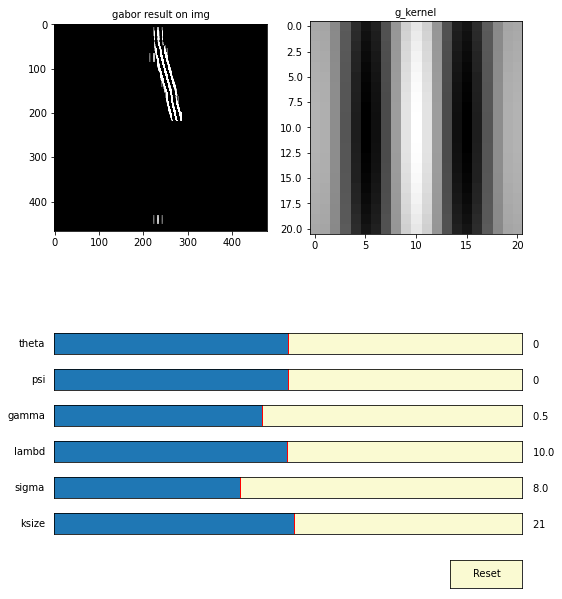

In [20]:
%matplotlib qt 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# read img and set gray color
img = cv2.imread('test_time_surface.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# dashboard settings
fig, (ax, ax_2) = plt.subplots(1, 2, figsize=(10,10))
plt.subplots_adjust(left=0.25, bottom=0.45)

# create slider spaces
axcolor = 'lightgoldenrodyellow'
ax_sliders = [plt.axes([0.25, 0.1 + 0.05 * i, 0.65, 0.03], facecolor=axcolor) for i in range(6)]

# define parameter sliders
ksize = Slider(ax_sliders[0], 'ksize', 1, 40, valinit=21, valstep=1)
sigma = Slider(ax_sliders[1], 'sigma', 0.1, 20.0, valinit=8, valstep=0.1)
lambd = Slider(ax_sliders[2], 'lambd', 0.1, 20.0, valinit=10, valstep=0.1)
gamma = Slider(ax_sliders[3], 'gamma', 0.1, 1, valinit=0.5, valstep=0.05)
psi = Slider(ax_sliders[4], 'psi', -10, 10, valinit=0, valstep=1)
theta = Slider(ax_sliders[5], 'theta', -5, 5, valinit=0, valstep=0.1)

sliders = [ksize, sigma, lambd, gamma, psi, theta]


def update(val):
    # on slider update recalculate gabor kernel
    g_kernel = cv2.getGaborKernel(ksize=(ksize.val, ksize.val),
                                  sigma=sigma.val,
                                  theta=np.pi / 4 * theta.val,
                                  lambd=lambd.val,
                                  gamma=gamma.val,
                                  psi=psi.val,
                                  ktype=cv2.CV_32F)
    # recalculate img result
    res = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)

    # show new img and gabor kernel
    ax.imshow(res, interpolation="nearest", cmap='gray')
    ax.set_title('gabor result on img', fontsize=10)
    ax_2.imshow(g_kernel, interpolation="nearest", cmap='gray')
    ax_2.set_title('g_kernel', fontsize=10)


for i in sliders:
    i.on_changed(update)

update(None)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    for slider in sliders:
        slider.reset()


button.on_clicked(reset)
plt.show()

%matplotlib inline

In [ ]:
np.shape(frames)

%matplotlib inline 
import matplotlib.pyplot as plt

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=(20,20))
    for axis, frame in zip(axes, frames):
        print(np.shape(frame))
        axis.imshow(frame[1])
        print(np.max(frame[1]))
        axis.axis("off")
    plt.tight_layout()
        
plot_frames(frames)

In [ ]:
### Now apply gabor filter in each event neighbourhood of 10x10



In [ ]:
sensor_size = tonic.datasets.DAVISDATA.sensor_size
sensor_size

In [ ]:
# turn into 3d numpy array for easy time surface manipulation 

# Combine x and y into indexable spatial coordinate 
event_xy = np.vstack((x,y))
np.shape(event_xy)

# Loop through every element to create time surface.
for polarity in p: 